<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E8%A8%88%E7%AE%97%E6%A8%A3%E6%9C%AC%E6%AC%8A%E9%87%8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from math import log,sqrt
import warnings 
warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pyplot as plt
from math import e

#切比雪夫距離
def 切比雪夫距離(x1,x2):
  return np.max(np.abs(x1-x2))
#歐式距離
def 歐式距離(x1,x2):
  return sqrt(sum((x1-x2)**2))

def count_distance(x1,x2s):
  distance = []
  x1 = np.array(x1)
  x2s = np.array(x2s)
  for x2 in x2s:
    distance.append(切比雪夫距離(x1,x2))
  return distance 

def tanh(x):
  return 2 / (1 + e**(-2*x)) -1

def get_sample_weight(distance):
  distance = np.array([ abs(d) for d in distance]) #距離絕對值
  sample_weight = 1/distance #距離愈遠重要度就低
  return [ tanh(x) for x in sample_weight]

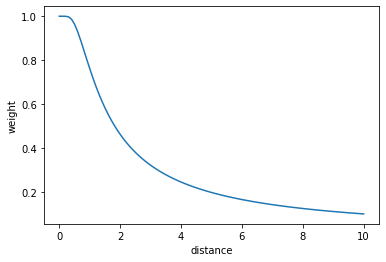

In [2]:
distance = np.linspace(0,10,100)
sample_weight = get_sample_weight(distance)
plt.plot(distance,sample_weight)
plt.xlabel('distance')
plt.ylabel('weight')
plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0)
train = train.append(test_250[test_250.index%5 != 0])
test = test_250[test_250.index%5 == 0]
print(train.shape)
print(test.shape)

(4721, 27)
(50, 27)


In [5]:
train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


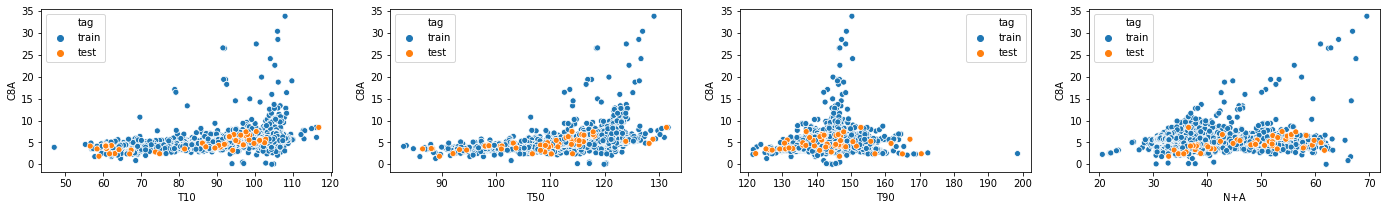

In [6]:
import seaborn as sns
train['tag'] = 'train'
test['tag'] = 'test'
features = train.iloc[:,:4].columns.tolist() 
y_name = 'C8A'
fig = plt.figure(figsize=(24,3))
for i,col in enumerate(features):
  plt.subplot(1,4,i+1)
  sns.scatterplot(x=col,y=y_name,data=train.append(test),hue='tag')
plt.show()

In [7]:
train[features+[y_name]].corr()

,T10,T50,T90,N+A,C8A
T10,1.000000,0.895777,0.222374,-0.262436,0.439352
T50,0.895777,1.000000,0.530693,-0.372622,0.466254
T90,0.222374,0.530693,1.000000,-0.219104,0.085083
N+A,-0.262436,-0.372622,-0.219104,1.000000,0.039334
C8A,0.439352,0.466254,0.085083,0.039334,1.000000


# select features

In [0]:
features = ['T10','T50','T90','N+A']

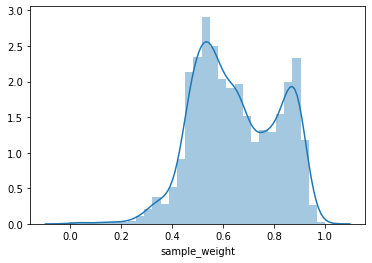

In [9]:
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
train['sample_weight'] = 0 
for row in tqdm(test.index):
  for feat in features:
    distance = count_distance(test.loc[row,[feat]+[y_name]],train.loc[:,[feat]+[y_name]])
    weight = get_sample_weight(distance)
    train['sample_weight'] += weight
train['sample_weight'] = MinMaxScaler().fit_transform(train[['sample_weight']])
sns.distplot(train['sample_weight'])

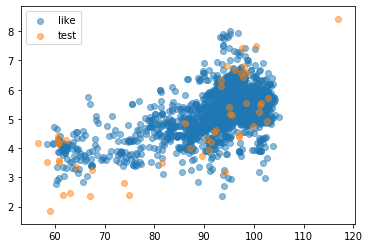

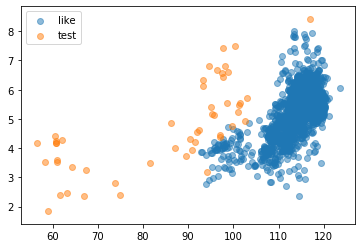

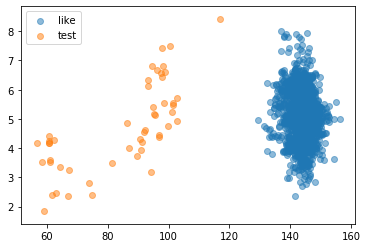

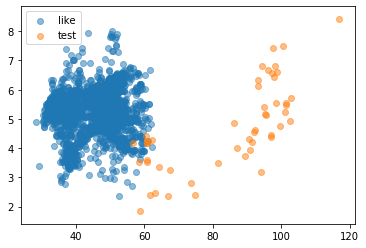

In [10]:
train['like'] = False
train.loc[train['sample_weight']>train['sample_weight'].quantile(0.5),'like'] = True
like_point = train.loc[train.like==True]
for x_col in features:
  plt.scatter(like_point[x_col],like_point[y_name],label='like',alpha=0.5)
  plt.scatter(test['T10'],test[y_name],label='test',alpha=0.5)
  plt.legend()
  plt.show()

# modeling

In [0]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,max_error
import numpy as np
from math import sqrt
def metric(y_t,y_p,name):
  res = {'R2':np.max((r2_score(y_t,y_p),0)),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error %':mean_absolute_error(y_t,y_p)/np.mean(y_t),
         'max_error':max_error(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

In [0]:
def pred_plot(df,by_col,name):
  df = df.sort_values(by = by_col)
  plt.plot(df[by_col],df['y_pred'],label= name+'_pred',color='red')
  plt.scatter(df[by_col],df[y_name],label= name+'_point')
  plt.xlabel(by_col)
  plt.ylabel(y_name)
  plt.legend()

In [13]:
by_col = abs(train[features+[y_name]].corr()[y_name].drop(y_name)).argmax()
by_col

'T50'

# 正常

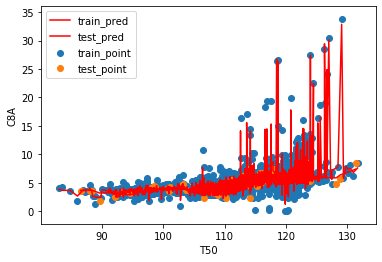

C8A


,R2,RMSE,mean_absolute_error %,max_error
train,0.885249,0.535185,0.057730,5.081665
test,0.777993,0.695964,0.112571,2.109124


In [14]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

X_train = train[features];y_train = train[y_name]
X_test = test[features];y_test = test[y_name]

model = CatBoostRegressor(n_estimators=1000,verbose=False)
model.fit(X_train,y_train,eval_set = (X_test,y_test))

train['y_pred'] = model.predict(X_train)
test['y_pred'] = model.predict(X_test)

pred_plot(train,by_col,'train')
pred_plot(test,by_col,'test')
plt.show()

print(y_name)
metric(train[y_name],train['y_pred'],'train').append(
metric(test[y_name],test['y_pred'],'test'))

# 給樣本權重

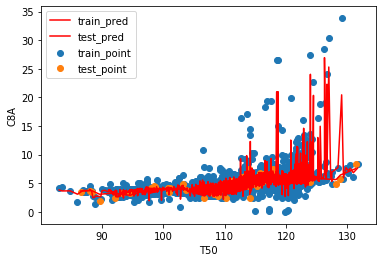

C8A


,R2,RMSE,mean_absolute_error %,max_error
train,0.806654,0.694695,0.062448,13.367320
test,0.844090,0.583231,0.097135,1.356588


In [15]:
model = CatBoostRegressor(n_estimators=1000,verbose=False)
model.fit(X_train,y_train,
          sample_weight=train['sample_weight'].values,
          eval_set = (X_test,y_test))

train['y_pred'] = model.predict(X_train)
test['y_pred'] = model.predict(X_test)

pred_plot(train,by_col,'train')
pred_plot(test,by_col,'test')
plt.show()

print(y_name)
metric(train[y_name],train['y_pred'],'train').append(
metric(test[y_name],test['y_pred'],'test'))

In [0]:
#C5IP ok 
#C5NP ok
#C5N 0.11
#C6IP 0.82
#C6NP 0.91
#C6N 0.91